# McsPyDataTools Tutorial for files from MCS Headstages with IMU<a id='Top'></a>

This tutorial shows the handling of IMU data collected from an MCS Headstage wearing an *Inertial Measurement Unit*

- <a href='#Gyrosocope Data'>Gyroscope Data</a>
- <a href='#Accelerometer Data'>Accelerometer Data</a>
- <a href='#6DoF-Estimation'>Combined 6-DoF Data</a>

Load module and the data file:

In [7]:
# These are the imports of the McsData module
import McsPy.McsData
import McsPy.functions_info as fi
from McsPy import ureg, Q_

# matplotlib.pyplot will be used in these examples to generate the plots visualizing the data
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.widgets import Slider
# These adjustments only need to be made so that the plot gets displayed inside the notebook
%matplotlib inline
# %config InlineBackend.figure_formats = {'png', 'retina'}

import os

# numpy is numpy ...
import numpy as np

Then, we need to define where the test data is located. This needs to be adjusted to your local setup! The McsPyDataTools toolbox includes a set of small test files in its `tests/TestData` folder. An archive with larger test files can be downloaded from the [Multi Channel DataManager](https://www.multichannelsystems.com/software/multi-channel-datamanager) page

In [ ]:
data_folder = r'..\McsPyDataTools\McsPy\tests\TestData' # adjust this to your local environment
fi.print_dir_file_info(data_folder)

Check what's inside the file:

In [9]:
acc_gyro_raw_data_file_path = os.path.join(data_folder, "2017-10-11T13-39-47McsRecording_X981_AccGyro.h5")
fi.print_file_info(acc_gyro_raw_data_file_path)


..\McsPyDataTools\McsPy\tests\TestData\2017-10-11T13-39-47McsRecording_X981_AccGyro.h5

Date                 Program                     Version
-------------------  --------------------------  ------------
2017-10-11 13:39:47  Multi Channel Experimenter  2.6.90.17257

Type    Stream                                         # ch
------  -------------------------------------------  ------
Analog  Data Acquisition (1) Quality Sideband Data1       1
Analog  Data Acquisition (1) Electrode Raw Data1         32
Analog  Data Acquisition (1) Analog Data1                 1
Analog  Data Acquisition (1) Digital Data1                1
Analog  Data Acquisition (1) Gyroscope Data1              3
Analog  Data Acquisition (1) Accelerometer Data1          3


Load the file in silent mode:

In [10]:
McsPy.McsData.VERBOSE = False
raw_data = McsPy.McsData.RawData(acc_gyro_raw_data_file_path)

## Gyroscope Data<a id='Gyroscope Data'></a>

In [11]:
gyro_channel = raw_data.recordings[0].analog_streams[4]
print('Channel IDs: %s' % gyro_channel.channel_infos.keys())

Channel IDs: dict_keys([148, 149, 150])


In [12]:
gyro = np.transpose(gyro_channel.channel_data)
gyro.shape

(16400, 3)

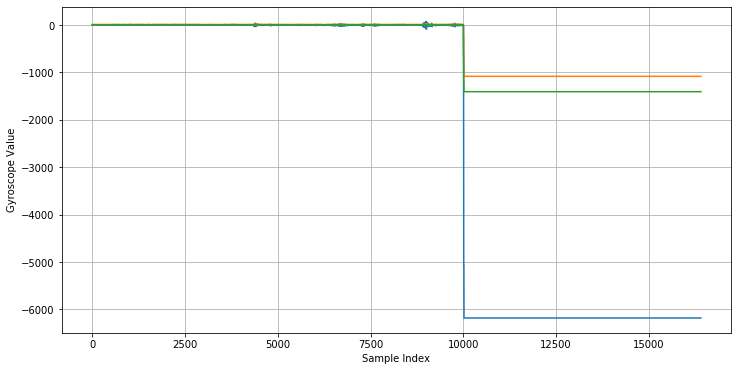

In [13]:
plt.figure(figsize=(12,6))
plt.plot(gyro)
#plt.title('Signal for Wireless (Simulation) / Raw ADC-Values (%s)' % analog_stream_0.label)
plt.xlabel('Sample Index')
plt.ylabel('Gyroscope Value')
plt.grid()

plt.show()

Remove invalid data parts:

In [14]:
gyro = gyro[0:10000,0:3]
gyro.shape

(10000, 3)

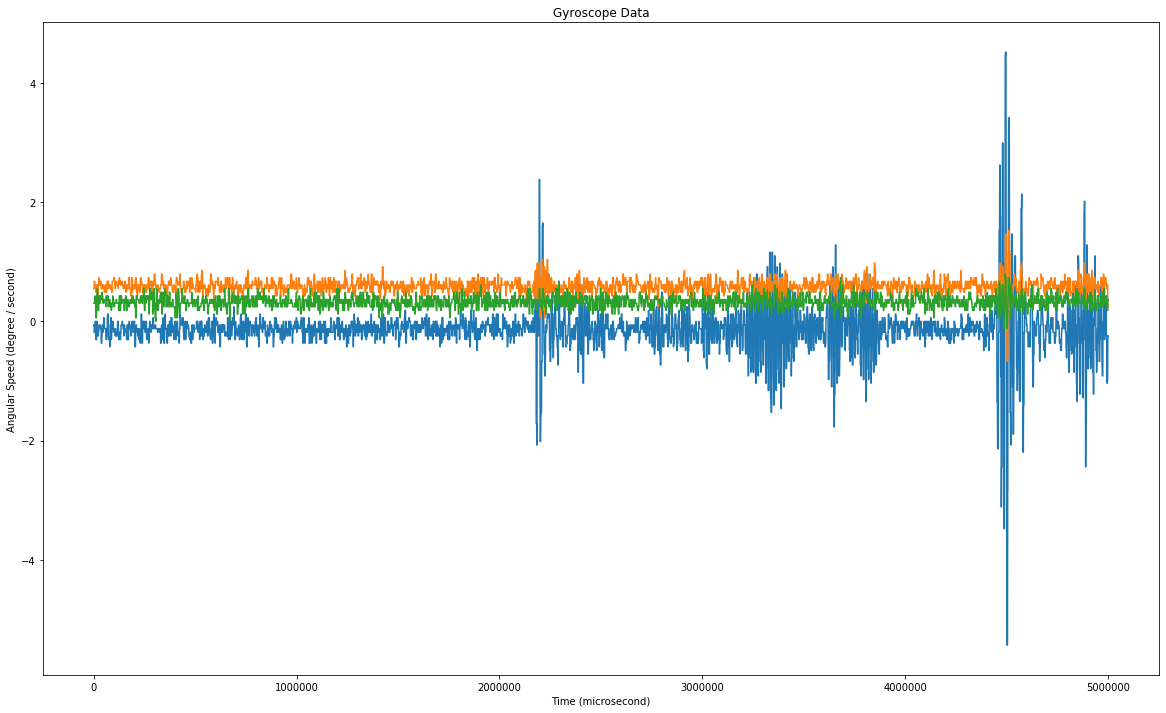

In [15]:
time = gyro_channel.get_channel_sample_timestamps(148,0,10000)
gyro_x = gyro_channel.get_channel_in_range(148,0,10000)
gyro_y = gyro_channel.get_channel_in_range(149,0,10000)
gyro_z = gyro_channel.get_channel_in_range(150,0,10000)
plt.figure(figsize=(20,12))
plt.plot(time[0], gyro_x[0])
plt.plot(time[0], gyro_y[0])
plt.plot(time[0], gyro_z[0])
plt.xlabel('Time (%s)' % time[1])
plt.ylabel('Angular Speed (%s)' % gyro_x[1])
plt.title('Gyroscope Data')
plt.show()

## Accelerometer Data<a id='Accelerometer Data'></a>

In [16]:
acc_channel = raw_data.recordings[0].analog_streams[5]
print('Channel IDs: %s' % acc_channel.channel_infos.keys())

Channel IDs: dict_keys([160, 161, 162])


In [17]:
acc = np.transpose(acc_channel.channel_data)
acc.shape

(16400, 3)

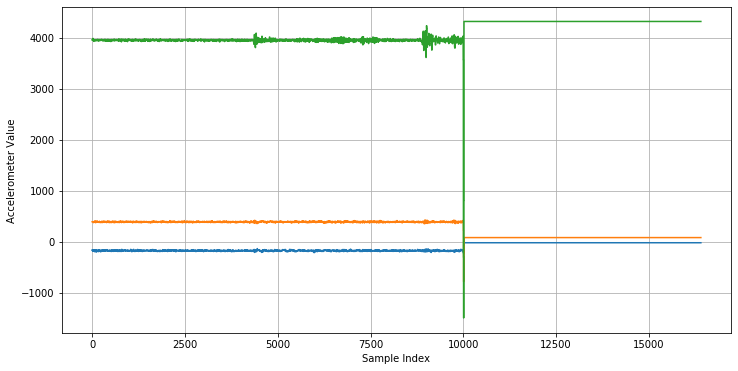

In [18]:
plt.figure(figsize=(12,6))
plt.plot(acc)
#plt.title('Signal for Wireless (Simulation) / Raw ADC-Values (%s)' % analog_stream_0.label)
plt.xlabel('Sample Index')
plt.ylabel('Accelerometer Value')
plt.grid()

plt.show()

Remove invalid data parts:

In [19]:
acc = acc[0:10000,0:3]
acc.shape

(10000, 3)

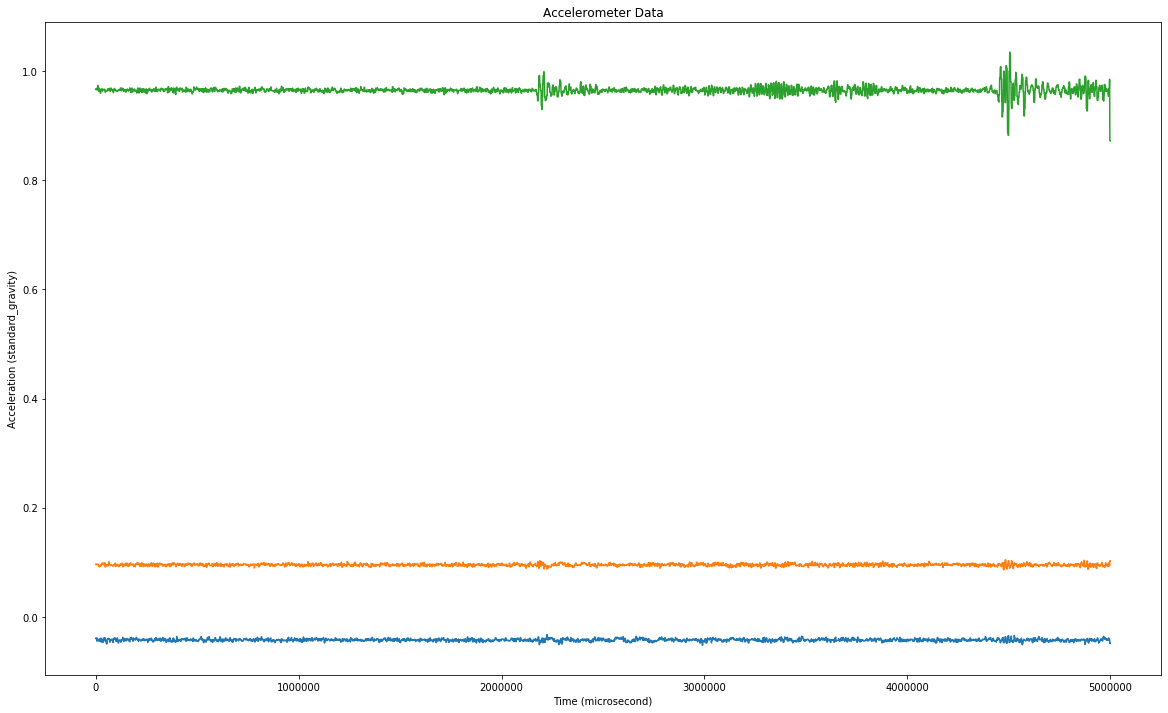

In [20]:
time = acc_channel.get_channel_sample_timestamps(160,0,10000)
acc_x = acc_channel.get_channel_in_range(160,0,10000)
acc_y = acc_channel.get_channel_in_range(161,0,10000)
acc_z = acc_channel.get_channel_in_range(162,0,10000)
plt.figure(figsize=(20,12))
plt.plot(time[0], acc_x[0])
plt.plot(time[0], acc_y[0])
plt.plot(time[0], acc_z[0])
plt.xlabel('Time (%s)' % time[1])
plt.ylabel('Acceleration (%s)' % acc_x[1])
plt.title('Accelerometer Data')
plt.show()

## Combined 6-DoF Data<a id='6DoF-Estimation'></a>

In [22]:
import skinematics as skin
from skinematics.imus import IMU_Base

from scipy import constants # for "g"

from mpl_toolkits.mplot3d import Axes3D


Load data and separate values from unit:

In [23]:
time, time_unit = gyro_channel.get_channel_sample_timestamps(148,0,10000)
gyro_x, gyro_x_unit = gyro_channel.get_channel_in_range(148,0,10000)
gyro_y, gyro_y_unit = gyro_channel.get_channel_in_range(149,0,10000)
gyro_z, gyro_z_unit = gyro_channel.get_channel_in_range(150,0,10000)

time, time_unit = acc_channel.get_channel_sample_timestamps(160,0,10000)
acc_x, acc_x_unit = acc_channel.get_channel_in_range(160,0,10000)
acc_y, acc_y_unit = acc_channel.get_channel_in_range(161,0,10000)
acc_z, acc_z_unit = acc_channel.get_channel_in_range(162,0,10000)

Define a new class for our data - derived from *IMU_Base* class in *scikit-kinematics*:

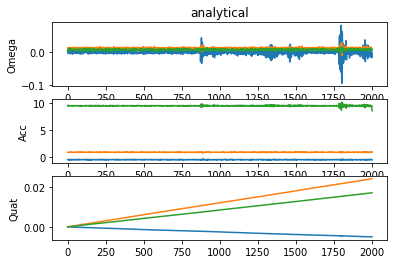

In [24]:
class McsIMU(IMU_Base):
    """Concrete class based on abstract base class IMU_Base """    
    
    def get_data(self, in_file, in_data):
        '''Get the sampling rate, as well as the recorded data,
        and assign them to the corresponding attributes of "self".
        
        Parameters
        ----------
        in_file : string
                Filename of the data-file
        in_data : 
                Sampling rate (has to be provided!!)
        
        Assigns
        -------
        - rate : rate
        - acc : acceleration
        - omega : angular_velocity
        '''
        
        # The sampling rate has to be provided externally
        rate = in_data['rate']
            
        # Get the data, and label them
        data.columns = ['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z', 'mag_x', 'mag_y', 'mag_z', 'taccgyr', 'tmag']
            
        # Set the conversion factors by hand, and apply them
        #conversions = {}
        #conversions['time'] = 1/1000000
        #conversions['acc'] = 9.81
        #conversions['gyr'] = np.pi/180   
        #data[:,:3] *= conversions['acc']
        #data[:,3:6] *= conversions['gyr']
        #data[:,6] *= conversions['time']
            
        returnValues = [rate]
        
        # Extract the columns that you want, by name
        #paramList=['acc', 'gyr', 'mag']
        #for param in paramList:
        #    Expression = param + '*'
        #    returnValues.append(data_interp.filter(regex=Expression).values)
        returnValues.append(in_data['acc'])
        returnValues.append(in_data['gyro'])
        self._set_info(*returnValues)

# Set the conversion factors by hand, and apply them
conversions = {}
conversions['time'] = 1/1000000
conversions['acc'] = constants.g
conversions['gyr'] = np.pi/180

acc = np.column_stack((acc_x, acc_y, acc_z)) * conversions['acc']
gyro = np.column_stack((gyro_x, gyro_y, gyro_z)) * conversions['gyr']
time_second = time * conversions['time']

acc_sub = acc[::5,:].copy()
gyro_sub = gyro[::5,:].copy()

initial_orientation = np.array([[1,0,0],
                                [0,1,0],
                                [0,0,1]])
in_data = {"rate" : 2000, "acc" : acc, "omega" : gyro, "mag": None}
in_data_subsampled = {"rate" : 400, "acc" : acc_sub, "omega" : gyro_sub, "mag": None}
#mcs_imu = McsIMU(in_file = None, R_init = initial_orientation, in_data = in_data)
mcs_imu = McsIMU(in_file = None, R_init = initial_orientation, in_data = in_data_subsampled)
# mcs_imu.get_data(None, {'rate': 2000, 'acc': acc, 'gyro': gyro})

def show_result(imu_data):
        fig, axs = plt.subplots(3,1)
        axs[0].plot(imu_data.omega)
        axs[0].set_ylabel('Omega')
        axs[0].set_title(imu_data.q_type)
        axs[1].plot(imu_data.acc)
        axs[1].set_ylabel('Acc')
        axs[2].plot(imu_data.quat[:,1:])
        axs[2].set_ylabel('Quat')
        plt.show()

show_result(mcs_imu)

<a href='#Top'>Back to index</a>

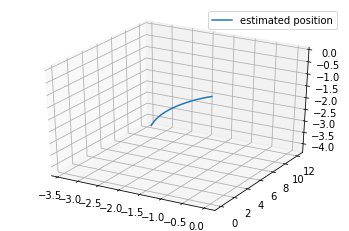

In [25]:
mcs_imu.q_type = 'analytical'
mcs_imu.calc_position()
pos_data = mcs_imu.pos

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(pos_data[:,0], pos_data[:,1], pos_data[:,2], label='estimated position')
ax.legend()

plt.show()